# GERMS-ML

## Meeting #4: Doing stuff

This week will be more coding focused. We're going to several different classifiers to the MNIST dataset and Jae's dataset.

### The MNIST dataset

It's MNIST! Our good from before! We'll start by reading in the dataset from `sklearn.datasets`:

In [1]:
%matplotlib inline 
from sklearn import datasets

digits = datasets.load_digits()

Now we'll split the separate datasets for the attributes and the targets:

In [2]:
digits_attributes = digits.data
digits_targets = digits.target

Before we do anything else, we'll separate the data into a training and a testing set:

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    digits_attributes, digits_targets, test_size = 0.2, random_state = 489
)


Take a few moments to remind yourself what the different datasets represent.

#### Preprocessing the data

There are no missing values, no outliers, and no oddities in the data for us to take care of, so the only real preprocessing we need to do with this dataset is feature scaling. We'll do standardization. 

Note that we're using pipelines now. It's not super necessary for this example since we're only doing one preprocessing step, but it will be much more useful when we move on to the groundwater data set.

Let's see what the data looks like before standardization:

In [4]:
x_train[:5, :5]

array([[ 0.,  0.,  0., 10.,  6.],
       [ 0.,  0.,  0.,  5., 15.],
       [ 0.,  1.,  9., 16., 15.],
       [ 0.,  0.,  1.,  5., 12.],
       [ 0.,  0.,  0.,  7., 11.]])

And after standardization:

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

digits_pipeline = Pipeline([
    ('standardize', StandardScaler())
])
x_train = digits_pipeline.fit_transform(x_train)

In [6]:
x_train[:5, :5]

array([[ 0.        , -0.33159794, -1.09096988, -0.41777192, -1.33283894],
       [ 0.        , -0.33159794, -1.09096988, -1.58711013,  0.74698804],
       [ 0.        ,  0.81938333,  0.81443369,  0.98543395,  0.74698804],
       [ 0.        , -0.33159794, -0.87925837, -1.58711013,  0.05371238],
       [ 0.        , -0.33159794, -1.09096988, -1.11937485, -0.17737951]])

#### Q1.

1. Why are we only calling `digits_pipeline.fit_transform` on the `x_train` dataset?

#### Applying a neural network to the data

Now to use a neural network to predict on the dataset. We're going to use the GridSearch function to optimize our model in a few moments, but let's just create a simple neural network to learn more about it. You can read about the various input parameters in the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), but for now, we'll just be messing with `hidden_layer_sizes` and `max_iter`. From the documentation:

* `hidden_layer_sizes` - the $i$th element represents the number of neurons in the $i$th hidden layer.
* `max_iter` - maximum number of iterations. The solver iterates until convergence or this number of iterations.

For now, we'll just make a neural network with 1 hidden layer and set the max iterations to 1000 (these numbers are arbitrary):

In [7]:
from sklearn.neural_network import MLPClassifier
nn_digits = MLPClassifier(hidden_layer_sizes = (10), 
                         max_iter = 1000)
nn_digits.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

Calling `.fit` from our model trains it on our data. Let's check out the performance of our model:

In [8]:
nn_digits.score(x_train, y_train)

1.0

That's a...very high score. Let's find out how well it does on the testing data:

In [9]:
nn_digits.score(x_test, y_test)

0.7055555555555556

That's a significant drop off. Let's visualize the confusion matrix and see if it tells us anything:

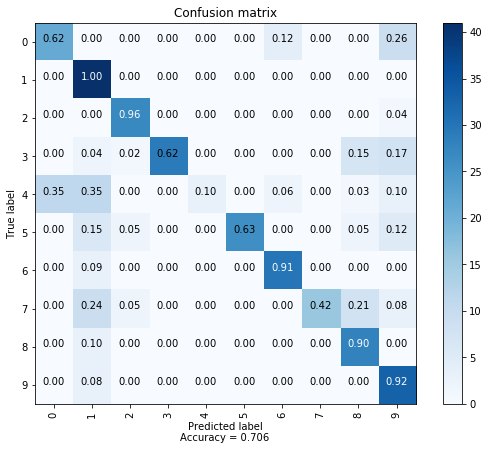

In [10]:
import sys
sys.path.insert(0, '../src')
from gml_utils.visualization import get_confusion_matrix

get_confusion_matrix(nn_digits, x_test, y_test);

#### Q2.

1. We made a pretty big mistake when evaluating our classifier performance on the testing set.  What was it?  Fix it.
2. Even though the seed is the same for the training-test split, there are differences in the model performance when we fit the neural network to the data. Why?

#### Tuning neural network hyperparameters

Before we actually go on to tuning hyperparameters, the error we made was that we didn't standardize the `x_test` dataset. Our model was trained on a standardized dataset, so when we used it to predict values on the non-standardized testing set, it naturally didn't perform well. Let's go ahead and fix that:

In [11]:
x_test = digits_pipeline.transform(x_test)

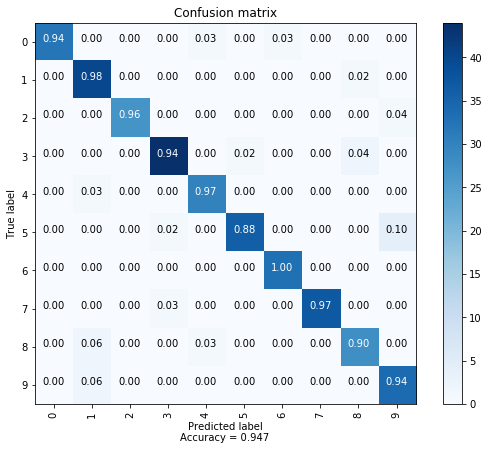

In [12]:
get_confusion_matrix(nn_digits, x_test, y_test)

Much better!

We chose the number of hidden layers arbitrarily. Let's use GridSearchCV to do a systematic search of the parameter space to best optimize our model's performance. Working off of the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), the hyperparameters we'll tune are:

* `activation` - The activation function for the hidden layer
* `hidden_layer_sizes` - This is the same as before
* `solver` - The solver for weight optimization

Since we're doing this together, I want to keep the search space relatively small. We'll talk more about solvers in a later lesson.

We start our hyperparameter tuning by importing `GridSearchCV` and creating the parameter grid to define our hyperparameter search space:

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'activation': ['relu', 'logistic'],
        'hidden_layer_sizes': [(10), (10, 10), (10, 10, 10)],
        'solver': ['adam', 'lbfgs']
    }
]

Next, we create a new neural network classifier. We'll set the `max_iter` argument to 1000 so that all of our models will have this setting. We'll then create a new `GridSearchCV` object and fit it to the data. I set `cv` to 5 instead of my normal 10 for time considerations.

In [14]:
nn_digits = MLPClassifier(max_iter = 1000)
grid_search = GridSearchCV(nn_digits, 
                           param_grid, 
                           cv = 5, 
                           n_jobs = -1)
grid_search.fit(x_train, y_train)

/anaconda3/envs/germsml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=1000,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'activation': ['relu', 'logistic'],
     

Recall that we can see what the hyperparameters belonging to the best model are by calling `.best_params_` on the `GridSearchCV` object:

In [15]:
grid_search.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': 10, 'solver': 'adam'}

It looks like the single hidden layer with the `adam` solver worked best, just like in our first guess. However, a logistic activation was more optimal compared to ReLU, our choice in the first model.  Let's see the score:

In [16]:
grid_search.best_score_

0.953375086986778

Not as impressive as the score we saw on our first model. Let's check the performance on the testing set:

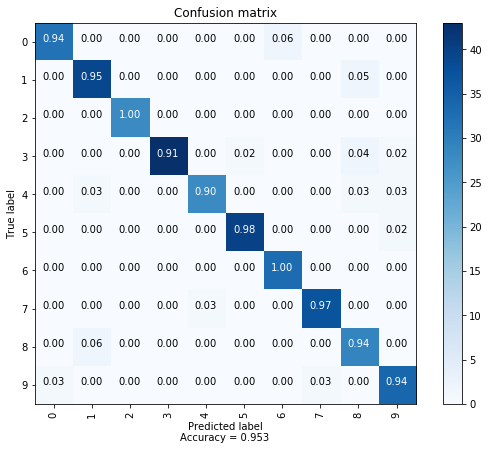

In [17]:
nn_digits = grid_search.best_estimator_
get_confusion_matrix(nn_digits, x_test, y_test)

#### Q3

* Depending on an element of randomness, the so-called "best" set of hyperparameters may perform worse on the testing set than our first original blind guess. Why do you think that is?
* You should have seen some red errors pop up while doing hyperparameter tuning. What do they mean?
* What are some next steps to continue tuning this model?

#### Other classifiers

Let's look at the [`scikit-learn` algorithm cheat-sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to see what models we might check out next:

![caption](https://scikit-learn.org/stable/_static/ml_map.png)

The first model that the cheat-sheet points us to is a linear support vector classifier, or SVC. You can read more about the support vector algorithm [here](https://en.wikipedia.org/wiki/Support-vector_machine).

Since our data is already split into testing and training sets and has been normalized already, all we need to do to make predictions is create a new model and fit it to the training data. 

In [18]:
from sklearn.svm import SVC
svc_digits = SVC()

We're going to skip straight to the hyperparameter tuning step for this classifier. The hyperparameter we are going to tune is $C$, the error term. [Wikipedia recommends](https://en.wikipedia.org/wiki/Support-vector_machine#Parameter_selection) the following range of values for $C$:

In [19]:
svc_param_grid = [
    {
        'C': [2 ** i for i in range(-5, 16)],
        'gamma': ['auto']
    }
]

Note that we set `gamma` to `auto` to avoid some annoying warnings. Now, the actual tuning:

In [20]:
svc_grid_search = GridSearchCV(svc_digits, svc_param_grid, cv = 5)
svc_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                                16, 32, 64, 128, 256, 512, 1024, 2048, 4096,
                                8192, 16384, 32768],
                          'gamma': ['auto']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

The best value of $C$ we found was:

In [21]:
svc_grid_search.best_params_

{'C': 2, 'gamma': 'auto'}

The accuracy of the model with this value of $C$ was:

In [22]:
svc_grid_search.best_score_

0.9832985386221295

And the performance of this best estimator on the testing set:

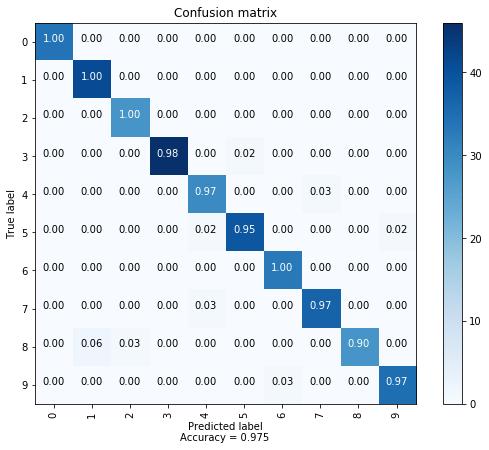

In [23]:
svc_digits = svc_grid_search.best_estimator_
get_confusion_matrix(svc_digits, x_test, y_test)



#### Q4

1. [Here](https://en.wikipedia.org/wiki/Support-vector_machine#Parameter_selection), Wikipedia also recommends some values to search through for `gamma`. Include these values in `svc_param_grid` and repeat the grid search.
2. Any thoughts about the relative performance of the SVC versus the neural net?
3. Try out other classifiers.

### The Groundwater dataset

Let's revisit the groundwater data set. We didn't actually make it predictions last time. We'll skip through the preprocessing and move to predictions.

#### Preprocessing

This time, we'll only read in the 3-month-adjusted dataset:

In [24]:
import pandas as pd
gw = pd.read_excel("../data/gw.xlsx", sheet_name = "Raw_Sorted_3month",
                  skiprows = [0])

Let's drop the non-numeric data for now:

In [25]:
gw.drop(["Internal Wel lID", "Date"], axis = 1,
                                   inplace = True)

Let's check how much data is missing in each category:

In [26]:
from gml_utils.preprocessing import get_missing_percentage
missing_percentage = get_missing_percentage(gw)
missing_percentage.sort_values(by = "percent_missing", ascending = False)

,percent_missing
NO2,22.994652
Ferrous,16.042781
tDCE,4.278075
Chloride,3.208556
NO3,3.208556
Redox,2.139037
DO,0.534759
pH,0.534759
Methane,0.000000
TCE,0.000000


Doesn't look too bad - most of the data is there, and there are enough values in the columns with higher missing percentages for us to impute missing values. 

Before we do get started with data preprocessing, let's split the data into a testing and training set. First, we separate our data into attributes and target sets. Our target is `DP (3month later)`, and the remaining columns will be our attributes:

In [27]:
gw_targets = gw["DP (3month later)"]
gw_targets.shape

(187,)

In [28]:
gw_attributes = gw.drop(columns = "DP (3month later)")

Now we split the data into testing and training sets:

In [29]:
gw_x_train, gw_x_test, gw_y_train, gw_y_test = train_test_split(
    gw_attributes, gw_targets, test_size = 0.2, random_state = 489
)

Last time, before we did any training on the dataset, we did imputation followed by standardization. Let's make a pipeline to do this for us.

In [30]:
from sklearn.impute import SimpleImputer

gw_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ("standardization", StandardScaler())
])

Now all we need to do is call `fit_transform` on our training data and it will be preprocessed. Let's look at the values before...

In [31]:
gw_x_train.describe()

,PCE,TCE,cDCE,tDCE,VC,Ethene,Dhc16S,Methane,pH,DO,Redox,NO3,NO2,Ferrous,Sulfate,TOC,Chloride
count,149.000000,149.000000,149.000000,143.000000,149.000000,149.000000,1.490000e+02,149.000000,149.000000,149.000000,147.000000,143.000000,115.000000,126.000000,149.000000,149.000000,143.000000
mean,1888.068389,304.903785,1207.266577,64.846783,1218.371409,472.142311,1.087982e+06,3484.081101,6.759732,1.926242,-68.503673,2.859741,0.589400,4.794603,46.659430,494.163490,65.279371
std,12679.776643,1204.025864,4626.077043,262.590985,4263.934981,2097.181516,5.894971e+06,5910.758338,0.563965,4.359515,100.070519,6.866195,1.113918,16.665491,87.338674,1457.250963,81.922656
min,0.000000,0.250000,0.350000,0.000000,0.340000,0.010000,1.000000e+01,0.013000,5.610000,0.020000,-445.000000,0.040000,0.100000,0.000000,0.000000,0.800000,2.400000
25%,0.550000,1.000000,14.900000,0.410000,2.200000,0.500000,6.770000e+01,38.000000,6.500000,0.340000,-116.350000,0.500000,0.500000,0.042500,5.000000,6.650000,22.800000
50%,1.700000,10.000000,110.000000,1.000000,64.600000,4.460000,2.000000e+04,613.000000,6.670000,0.610000,-78.200000,0.500000,0.500000,0.390000,29.000000,14.200000,32.800000
75%,9.700000,74.000000,800.000000,6.500000,310.000000,99.200000,2.800000e+05,4500.000000,6.860000,1.880000,-25.500000,2.000000,0.500000,1.192500,56.500000,59.300000,72.100000
max,108700.000000,10000.000000,51000.000000,2100.000000,38000.000000,19200.000000,5.500000e+07,34600.000000,9.160000,47.100000,226.800000,63.900000,12.000000,100.000000,666.000000,8300.000000,460.000000


...and compare them to the values after our preprocessing pipeline:

In [32]:
gw_x_train = pd.DataFrame(gw_pipeline.fit_transform(gw_x_train),
                          columns = gw_x_train.columns)

In [33]:
gw_x_train.describe()

,PCE,TCE,cDCE,tDCE,VC,Ethene,Dhc16S,Methane,pH,DO,Redox,NO3,NO2,Ferrous,Sulfate,TOC,Chloride
count,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,149.000000,149.000000
mean,3.576557e-17,-3.874604e-17,-1.788279e-17,5.960929e-18,5.960929e-18,2.980464e-17,6.706045e-18,-5.960929e-18,1.454467e-15,3.576557e-17,1.922400e-16,1.192186e-17,-7.153115e-17,2.682418e-17,-9.984556e-17,0.000000,0.000000
std,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373,1.003373
min,-1.494061e-01,-2.538827e-01,-2.617741e-01,-2.426433e-01,-2.866224e-01,-2.258863e-01,-1.851817e-01,-5.914332e-01,-2.045533e+00,-4.387347e-01,-3.799213e+00,-4.055242e-01,-4.809930e-01,-2.681085e-01,-5.360374e-01,-0.339700,-0.767441
25%,-1.493626e-01,-2.532576e-01,-2.586183e-01,-2.410458e-01,-2.861848e-01,-2.256519e-01,-1.851719e-01,-5.849848e-01,-4.620987e-01,-3.650845e-01,-4.811642e-01,-3.370617e-01,-7.076443e-02,-2.641990e-01,-4.785959e-01,-0.335672,-0.510678
50%,-1.492716e-01,-2.457575e-01,-2.379916e-01,-2.387470e-01,-2.715010e-01,-2.237573e-01,-1.817793e-01,-4.873764e-01,-1.596449e-01,-3.029421e-01,-9.656535e-02,-3.370617e-01,-7.076443e-02,-2.426966e-01,-2.028768e-01,-0.330473,-0.388528
75%,-1.486385e-01,-1.924232e-01,-8.833406e-02,-2.188761e-01,-2.137544e-01,-1.784300e-01,-1.375251e-01,1.724559e-01,1.783916e-01,-1.064283e-02,4.303654e-01,-1.733469e-01,-7.076443e-02,-2.009950e-01,1.130514e-01,-0.299420,0.100069
max,8.452213e+00,8.079390e+00,1.079979e+01,7.939527e+00,8.655311e+00,8.960131e+00,9.176270e+00,5.282040e+00,4.270413e+00,1.039705e+01,2.982244e+00,9.098863e+00,1.172331e+01,6.247765e+00,7.115169e+00,5.374615,4.936188


And we might as well preprocess the testing attributes while we're at it:

In [34]:
gw_x_test = pd.DataFrame(gw_pipeline.fit_transform(gw_x_test),
                        columns = gw_x_train.columns)

We're ready to train some models.

#### Q4

1. We dropped Well ID and Date as unimportant. What potential problems are there by doing this?

#### Random Forest Classifier

We're going to skip right to parameter tuning. You can read about Random Forests [here](https://en.wikipedia.org/wiki/Random_forest). In short, a random forest classifier is a collection of resampled decision trees (or a "bootstrap aggregation" or "bagged"). The idea is that while an individual tree may not be very accurate in terms of predictive powers, a collection of many trees tends to be more accurate when we take the majority vote as the prediction.

The parameters we'll be tuning are:

* `n_estimators` - the number of trees in the forest
* `max_features` - the number of features to consider when looking for the best split

You can read more about these hyperparameters (and all the other ones) at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [35]:
from sklearn.ensemble import RandomForestClassifier

gw_rf = RandomForestClassifier()

rf_param_grid = [
    {
        'n_estimators': [50 * (i + 1) for i in range(4)],
        'max_features': ['sqrt', 'log2']
    }
]

rf_grid_search = GridSearchCV(gw_rf, 
                              rf_param_grid, 
                              cv = 5,
                              n_jobs = -1)
rf_grid_search.fit(gw_x_train, gw_y_train)

/anaconda3/envs/germsml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

The best score:

In [36]:
rf_grid_search.best_score_

0.7718120805369127

The best parameters

In [37]:
rf_grid_search.best_params_

{'max_features': 'log2', 'n_estimators': 100}

Let's see the performance on the test set:

In [38]:
gw_rf = rf_grid_search.best_estimator_

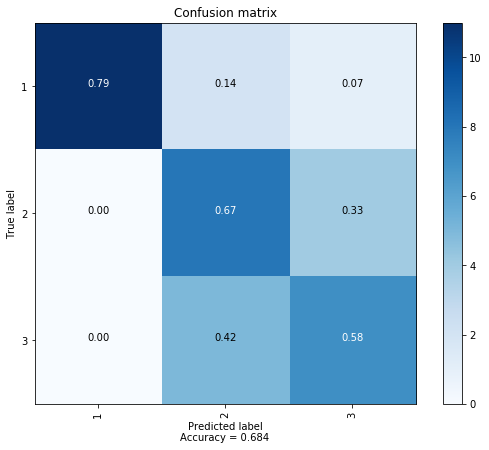

In [39]:
get_confusion_matrix(gw_rf, gw_x_test, gw_y_test)

Yucky.

#### Q5.

1. Tune the random forest.
2. Train some other models.
3. What else can we do to improve the prediction accuracy?